In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch

from pathlib import Path
from torch.utils.data import Dataset, DataLoader

In [4]:
dset_path = Path('./data/data_NS.hdf5')

In [5]:
with h5py.File(dset_path) as f:
    waveforms = f['x_train']
    m1s = f['m1_train']
    m2s = f['m2_train']
    wvf = waveforms[100]
    min_peak = min([max(waveforms[idx]) for idx in range(500)])
    max_mass = max([m1s[idx] for idx in range(5000)])
    assert len(waveforms) == len(m1s) == len(m2s)

In [6]:
with h5py.File(dset_path) as f:
    a = f.keys()
    print(a)

<KeysViewHDF5 ['m1_train', 'm2_train', 'x_train']>


In [7]:
max_mass

array([2.])

In [8]:
waveforms.shape

(50000, 1024)

In [9]:
m1s.shape

(50000, 1)

In [10]:
m2s.shape

(50000, 1)

In [11]:
wvf

array([ 2.42838589e-01,  2.79441851e-01,  3.06731950e-01, ...,
       -2.65579820e-04,  3.37492693e-05,  6.82811904e-06])

In [12]:
min_peak

1.0

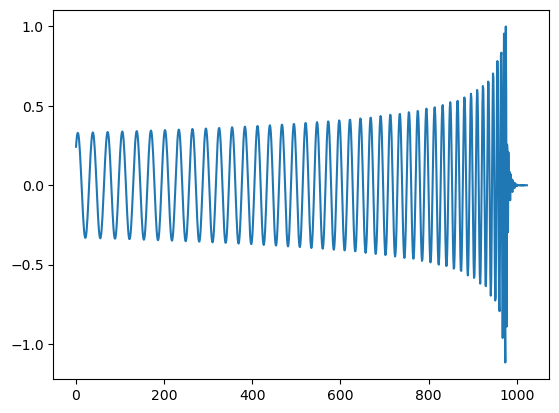

In [13]:
plt.plot(wvf)

In [14]:
1024 * 8

8192

In [42]:
class Waveform_Dataset(Dataset):
    def __init__(self, dset_path, transform=None):
        self.dset_path = Path(dset_path)
        self.transform = transform
        with h5py.File(dset_path) as f:
            self.length = len(f[list(f.keys())[0]])
    
    def __getitem__(self, idx):
        assert type(idx) == int, "Sample index should be a integer number."
        assert idx >= 0 and idx < self.length, f"Sample index should be between 0 and {self.length}."
        with h5py.File(dset_path) as f:
            waveform = f['x_train'][idx]
            m1 = f['m1_train'][idx]
            m2 = f['m2_train'][idx]    
            
        if self.transform:
            waveform = self.transform(waveform)
        
        labels = {
            'mass1': m1,
            'mass2': m2,
        }
        
        return waveform, labels
            
    def __len__(self):
        return self.length

In [43]:
transform = lambda x: torch.from_numpy(x).float()

dset = Waveform_Dataset(dset_path, transform=transform)

In [44]:
sample = dset[0]

In [45]:
tt_wvf = sample[0]

In [46]:
tt_wvf.shape

torch.Size([1024])

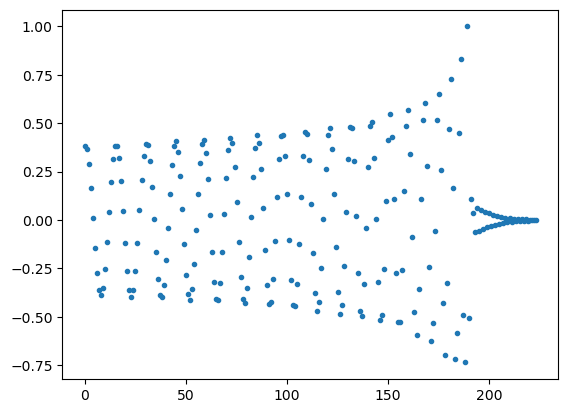

In [47]:
plt.plot(tt_wvf[800:], '.')

In [48]:
int_wvf = np.interp(np.linspace(0, 1, 16384), np.linspace(0, 1, 1024), tt_wvf)

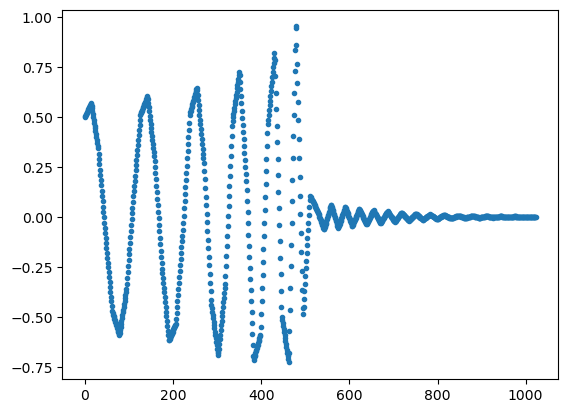

In [49]:
plt.plot(int_wvf[-1024:], '.')

In [50]:
def my_transform(x):
    x = np.interp(np.linspace(0, 1, 16384), np.linspace(0, 1, 1024), x)
    return torch.from_numpy(x).float()

interp_dset = Waveform_Dataset(dset_path, transform=my_transform)

In [51]:
dloader = DataLoader(dset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)

In [52]:
from train import train_WaveGAN

In [53]:
2**14

16384

In [32]:
params = {
    'n_channels': 1,
    'waveform_length': 16384,
    'use_batchnorm': False,
    'cuda': torch.cuda.is_available(),
    'lr_g': 1e-4,
    'lr_d': 3e-4,
    'betas': (0.5, 0.9),
    'n_epochs': 10,
    'disc_repeats': 1,
    'z_dim': 100,
    'c_lambda': 10,
    'display_step': 1 
}

In [55]:
train_WaveGAN(dloader, params)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

KeyboardInterrupt: 